# EDA

The purpose of this notebook will be to explore the datasets and get an idea of how I can accomplish the project goal

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

First, I want to create three dataframes from the three .csv files containing housing info

In [5]:
# Property Sales
ps_df = pd.read_csv('../../data/EXTR_RPSale.csv')

# Building Info
b_df = pd.read_csv('../../data/EXTR_ResBldg.csv')

# Parcel info
p_df = pd.read_csv('../../data/EXTR_Parcel.csv', encoding='latin-1')



The property sales dataframe holds information on property sales in King County since they started keeping track of them. For the purpose of this project I only want to focus on the property sales in 2019, so I will filter the dataframe to have only the sales from the year 2019.

In [7]:
# Create filter, true if 2019, false otherwise
year = [True if int(d[6:]) == 2019 else False for d in ps_df['DocumentDate']]

ps_df = ps_df[year]


Now the property sales dataframe only contains info from 2019.

In order to combine the three dataframes, I will use the 'Major' and 'Minor' columns. However, while importing them with pandas some of the leading zeros have been lost. Looking at the documentation for the tables, I know the 'Major' column should be length six and 'Minor' of length four in all three dataframes. I will now create two functions to add leading zeros to both Major and Minor codes.

In [50]:
def add_minor_leading_zeros(minors):
    # Empty list to store formatted minor codes in
    f_minors = []
    
    # loop through current minors and add leading zeros
    for minor in minors:
        #convert minor to str and split
        s = [num for num in str(minor)]
        # length of current minor code
        l = len(s)
        # list with 4 zeros
        f_minor = ['0', '0', '0', '0']
        # take current minor and add to end of list
        f_minor[4-l:] = s
        #join list into str
        f_minor = ''.join(f_minor)
        # convert to int append to formatted minors list
        f_minors.append(f_minor)
    
    return f_minors

In [59]:
def add_major_leading_zeros(majors):
    # Empty list to store formatted major codes in
    f_majors = []
    
    # loop through current majors and add leading zeros
    for major in majors:
        #convert major to str and split
        s = [num for num in str(major)]
        # length of current major code
        l = len(s)
        # list with 6 zeros
        f_major = ['0', '0', '0', '0', '0', '0']
        # take current major and add to end of list
        f_major[6-l:] = s
        #join list into str
        f_major = ''.join(f_major)
        # convert to int append to formatted majors list
        f_majors.append(f_major)
    
    return f_majors

In [76]:
# Function that calls both add leading zeros function
def add_leading_zeros(majors, minors):
    return add_major_leading_zeros(majors), add_minor_leading_zeros(minors)

My group decided to taylor our project towards first time homebuyers. To give this audience the most valuable information possible, we decided to initially explore the following claims:
- Having a front porch increases home sale price
- A house filling a larger proportion of the overall lot decreases sale price
- The presence of a nuisance (power lines, airport noises, traffic noises) decreases sale price

With this information, I can better judge which columns I need to select from the dataframe to perform the Linear Regression

To join the information between the dataframes, I will use the 'Major' and 'Minor' columns from each dataframe. In order to do that, I will make sure they are all formatted correctly using the functions defined above.

In [78]:
# Format major and minor columns for each dataframe
ps_df['Major'], ps_df['Minor'] = add_leading_zeros(ps_df['Major'], ps_df['Minor'])
b_df['Major'], b_df['Minor'] = add_leading_zeros(b_df['Major'], b_df['Minor'])
p_df['Major'], p_df['Minor'] = add_leading_zeros(p_df['Major'], p_df['Minor'])

In [82]:
ps_df.columns

Index(['ExciseTaxNbr', 'Major', 'Minor', 'DocumentDate', 'SalePrice',
       'RecordingNbr', 'Volume', 'Page', 'PlatNbr', 'PlatType', 'PlatLot',
       'PlatBlock', 'SellerName', 'BuyerName', 'PropertyType', 'PrincipalUse',
       'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse',
       'AFHistoricProperty', 'SaleReason', 'PropertyClass', 'SaleWarning'],
      dtype='object')

In [83]:
b_df.columns

Index(['Major', 'Minor', 'BldgNbr', 'NbrLivingUnits', 'Address',
       'BuildingNumber', 'Fraction', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'BldgGradeVar', 'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor',
       'SqFtUpperFloor', 'SqFtUnfinFull', 'SqFtUnfinHalf', 'SqFtTotLiving',
       'SqFtTotBasement', 'SqFtFinBasement', 'FinBasementGrade',
       'SqFtGarageBasement', 'SqFtGarageAttached', 'DaylightBasement',
       'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck', 'HeatSystem',
       'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFreestanding', 'FpAdditional', 'YrBuilt',
       'YrRenovated', 'PcntComplete', 'Obsolescence', 'PcntNetCondition',
       'Condition', 'AddnlCost'],
      dtype='object')

In [84]:
p_df.columns

Index(['Major', 'Minor', 'PropName', 'PlatName', 'PlatLot', 'PlatBlock',
       'Range', 'Township', 'Section', 'QuarterSection', 'PropType', 'Area',
       'SubArea', 'SpecArea', 'SpecSubArea', 'DistrictName', 'LevyCode',
       'CurrentZoning', 'HBUAsIfVacant', 'HBUAsImproved', 'PresentUse',
       'SqFtLot', 'WaterSystem', 'SewerSystem', 'Access', 'Topography',
       'StreetSurface', 'RestrictiveSzShape', 'InadequateParking',
       'PcntUnusable', 'Unbuildable', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'WfntFootage', 'WfntBank', 'WfntPoorQuality', 'WfntRestrictedAccess',
       'WfntAccessRights', 'WfntProximityInfluence', 'TidelandShoreland',
       'LotDepthFactor', 'TrafficNoise', 'AirportNoise', 'PowerLines',
       'OtherNuisances', 'NbrBldgSites', 'Contamination', 'DNRLease',
       'AdjacentGolfFairway', 'AdjacentGreenbelt', 

I would like to select columns pertaining to sale price, home information (square footage, porch, surrounding area), the presence of nuisances, and lot size to start. I want to select that information from the respective dataframe and use it to create another dataframe containing all the information relevant to my analysis.

In [117]:
ps_columns = [ps_df['Major'], ps_df['Minor'], ps_df['SalePrice']]
b_columns = [b_df['Major'], b_df['Minor'], b_df['SqFt1stFloor'], b_df['SqFtTotLiving'],
                b_df['SqFtOpenPorch'], b_df['SqFtEnclosedPorch'], b_df['SqFtGarageAttached']]
p_columns = [p_df['Major'], p_df['Minor'], p_df['SqFtLot'], p_df['TrafficNoise'], p_df['AirportNoise'],
                p_df['PowerLines'], p_df['OtherNuisances']]
cols = ps_columns + b_columns + p_columns
df = pd.concat(cols, axis=1)
df.head()

,Major,Minor,SalePrice,Major,Minor,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,Major,Minor,SqFtLot,TrafficNoise,AirportNoise,PowerLines,OtherNuisances
0,NaN,NaN,NaN,009800,0440,2280.0,4600.0,110.0,0.0,820.0,807841,0410,7424.0,0.0,0.0,N,N
1,NaN,NaN,NaN,009800,0710,2360.0,4310.0,50.0,0.0,840.0,201920,0030,8443.0,0.0,0.0,N,N
2,NaN,NaN,NaN,009800,0720,1970.0,4100.0,0.0,0.0,750.0,755080,0015,5000.0,0.0,0.0,N,N
3,NaN,NaN,NaN,009802,0030,1840.0,3720.0,60.0,0.0,710.0,888600,0135,277041.0,0.0,0.0,N,N
4,NaN,NaN,NaN,009802,0140,1610.0,3010.0,380.0,0.0,660.0,643000,0185,4080.0,0.0,0.0,N,Y


Using the concat method did not get the exact results I wanted, so I am going to try the merge method instead. I may have to use it twice but as long as I get the correct dataframe right now I do not mind.

In [136]:
ps_columns = ['Major', 'Minor', 'SalePrice']
b_columns = ['Major', 'Minor', 'SqFt1stFloor', 'SqFtTotLiving', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtGarageAttached']
p_columns = ['Major', 'Minor', 'SqFtLot', 'TrafficNoise', 'AirportNoise', 'PowerLines', 'OtherNuisances']
df = ps_df[ps_columns].merge(b_df[b_columns], how='inner', on=['Major', 'Minor']).merge(p_df[p_columns], how='inner', on=['Major', 'Minor'])
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,AirportNoise,PowerLines,OtherNuisances
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,N,N
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,N,N
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,N,N
3,779790,0030,0,730,890,0,0,0,5000,0,0,N,N
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,N,N


It seems like that worked the way I wanted it to. Now I can begin doing some data exploration before I start creating my model. I need to check for missing data, and get a better understanding of what the values in each column mean.

In [109]:
# Check for missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43838 entries, 0 to 43837
Data columns (total 13 columns):
Major                 43838 non-null object
Minor                 43838 non-null object
SalePrice             43838 non-null int64
SqFt1stFloor          43838 non-null int64
SqFtTotLiving         43838 non-null int64
SqFtOpenPorch         43838 non-null int64
SqFtEnclosedPorch     43838 non-null int64
SqFtGarageAttached    43838 non-null int64
SqFtLot               43838 non-null int64
TrafficNoise          43838 non-null int64
AirportNoise          43838 non-null int64
PowerLines            43838 non-null object
OtherNuisances        43838 non-null object
dtypes: int64(9), object(4)
memory usage: 4.7+ MB


The dataframe has no missing values which is very convenient. Besides two of the columns I will be working with, all the data is numeric which is also very nice. The majority of the data is rather straightforward. Sales price and the square footage information are just numbers. The nuisance columns need to be explored a little more. According the the lookup information, Traffic Noise is either a 1, 2, or 3. Meaning moderate, high, or extreme traffic noise respectively. I need to explore the other three a bit more to figure out what each of them mean.

In [110]:
df['AirportNoise'].value_counts()

0    43838
Name: AirportNoise, dtype: int64

Looks like none of the houses in the dataframe have any airport noise, so I can drop that column altogether.

In [147]:
df.drop('AirportNoise', axis=1, inplace=True)
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,0
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,0
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,0
3,779790,0030,0,730,890,0,0,0,5000,0,0,0
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,0


In [137]:
df['PowerLines'].value_counts()

N    43377
Y      461
Name: PowerLines, dtype: int64

In [138]:
df['OtherNuisances'].value_counts()

N    42395
Y     1443
Name: OtherNuisances, dtype: int64

Both the power lines and other nuisances columns are categorical and are binary, either yes or no. Knowing this, I can utilize LabelEncoder to convert it to numeric binary column, so the Y and N will be replaced with 0 and 1. I think that will be a little easier to work with.

In [125]:
from sklearn.preprocessing import LabelEncoder

In [126]:
le = LabelEncoder()

In [142]:
pl_encoded = le.fit_transform(list(df['PowerLines']))
pd.Series(pl_encoded).value_counts()

0    43377
1      461
dtype: int64

That worked. Now all the homes with Power Lines have a 1 in the PowerLines column, and a 0 if not. I can set that equal to the PowerLines column and do the same thing for the OtherNuisances column

In [143]:
df['PowerLines'] = pd.Series(pl_encoded)
df['PowerLines'].value_counts()

0    43377
1      461
Name: PowerLines, dtype: int64

In [144]:
on_encoded = le.fit_transform(list(df['OtherNuisances']))
pd.Series(on_encoded).value_counts()

0    42395
1     1443
dtype: int64

In [145]:
df['OtherNuisances'] = pd.Series(on_encoded)
df['OtherNuisances'].value_counts()

0    42395
1     1443
Name: OtherNuisances, dtype: int64

In [148]:
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,0
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,0
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,0
3,779790,0030,0,730,890,0,0,0,5000,0,0,0
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,0


I need to do a little more processing before I begin to explore my model. I need a column that denotes whether or not the home observation has a porch. I also need a column that represents the proportion of the overall lot that the house takes up. For whether or not the hosue has a porch, I want another binary column that is going to be 1 if 'SqFtOpenPorch' or 'SqFtEnclosedPorch' is greater than 0, and zero if both of those columns are zero. The proportion column is going to be ('SqFt1stFloor' + 'SqFtGarageAttached') / 'SqFtLot'. It's my understanding the best way to represent the area of land the house takes up would be to sum the first floor and garage square footage.

In [150]:
# Create binary porch column
has_porch = [1 if ((op > 0) | (ep > 0)) else 0 for op, ep in zip(df['SqFtOpenPorch'], df['SqFtEnclosedPorch'])]
df['has_porch'] = has_porch

In [151]:
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances,has_porch
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,0,1
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,0,1
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,0,1
3,779790,0030,0,730,890,0,0,0,5000,0,0,0,0
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,0,0


Porch column is done. Now I need want to create a column, 'total_ground_sq_ft' which is the sum of first floor and garage square footage. From that column I can create one more column, 'prop_lot', which is 'total_ground_sq_ft'/'SqFtLot'

In [152]:
df['total_ground_sq_ft'] = df['SqFt1stFloor'] + df['SqFtGarageAttached']
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances,has_porch,total_ground_sq_ft
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,0,1,2480
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,0,1,1522
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,0,1,1480
3,779790,0030,0,730,890,0,0,0,5000,0,0,0,0,730
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,0,0,1240


In [153]:
df['prop_lot'] = df['total_ground_sq_ft']/df['SqFtLot']
df.head()

,Major,Minor,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances,has_porch,total_ground_sq_ft,prop_lot
0,213043,0120,560000,1930,1930,180,0,550,10523,0,0,0,1,2480,0.235674
1,940652,0630,435000,1057,1975,45,0,465,7392,0,0,0,1,1522,0.205898
2,140281,0020,450000,1080,1080,110,0,400,9940,0,0,0,1,1480,0.148893
3,779790,0030,0,730,890,0,0,0,5000,0,0,0,0,730,0.146000
4,124550,0098,193000,1140,1760,0,0,100,9670,1,0,0,0,1240,0.128232


Now that I have the information I am interested in, I want to do one final check of the dataframe and drop the rows that have a saleprice of 0, because those will likely mess up the model.

First I'll check how many rows have a sale price of zero

In [154]:
len(df[df['SalePrice'] == 0])

13894

In [155]:
df.shape

(43838, 15)

That's going to drop my number of observations by 13000. I think I am going to create another dataframe which doesn't contain sales price of 0 and let this one be. Then I can model both and see how it affects the model.

In [156]:
non_zero_df = df[df['SalePrice']>0]

In [157]:
non_zero_df.shape

(29942, 15)

Now I need to check for duplicates

In [166]:
sum(non_zero_df.duplicated() == True)

438

Now I can begin to develop my model. First I want to check the correlation between the different variables in the dataframe. 

In [158]:
non_zero_df.corr()

,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances,has_porch,total_ground_sq_ft,prop_lot
SalePrice,1.000000,0.178004,0.246102,0.124826,0.023340,0.109171,-0.026014,-0.010970,-0.010140,-0.007733,0.084929,0.179507,0.029477
SqFt1stFloor,0.178004,1.000000,0.683955,0.304927,0.010010,0.411531,-0.064735,-0.076944,0.025320,-0.078713,0.164888,0.923545,-0.244303
SqFtTotLiving,0.246102,0.683955,1.000000,0.419998,-0.010571,0.458088,-0.070458,-0.082853,0.018514,-0.068661,0.319039,0.705980,0.002699
SqFtOpenPorch,0.124826,0.304927,0.419998,1.000000,-0.011777,0.225108,-0.002317,-0.034010,0.019614,-0.022538,0.492110,0.323532,-0.038924
SqFtEnclosedPorch,0.023340,0.010010,-0.010571,-0.011777,1.000000,-0.046073,-0.005966,0.035885,-0.008141,0.006131,0.142635,-0.011875,-0.025385
SqFtGarageAttached,0.109171,0.411531,0.458088,0.225108,-0.046073,1.000000,-0.038024,-0.133155,0.041661,-0.084631,0.231632,0.729579,-0.003218
SqFtLot,-0.026014,-0.064735,-0.070458,-0.002317,-0.005966,-0.038024,1.000000,0.144695,-0.001162,-0.008507,0.003521,-0.064576,-0.096009
TrafficNoise,-0.010970,-0.076944,-0.082853,-0.034010,0.035885,-0.133155,0.144695,1.000000,-0.010846,0.044811,-0.038156,-0.113765,-0.030621
PowerLines,-0.010140,0.025320,0.018514,0.019614,-0.008141,0.041661,-0.001162,-0.010846,1.000000,0.007317,0.004470,0.036530,-0.056903
OtherNuisances,-0.007733,-0.078713,-0.068661,-0.022538,0.006131,-0.084631,-0.008507,0.044811,0.007317,1.000000,-0.035195,-0.094675,0.029960


Well the variables I was most interested in seem to have some of the smallest impacts on salesprice. Square footage seems to have the highest correlation with sales price, which makes sense. I want to compare the correlations above with the correlations if I had left the 0's in for sales prices.

In [159]:
df.corr()

,SalePrice,SqFt1stFloor,SqFtTotLiving,SqFtOpenPorch,SqFtEnclosedPorch,SqFtGarageAttached,SqFtLot,TrafficNoise,PowerLines,OtherNuisances,has_porch,total_ground_sq_ft,prop_lot
SalePrice,1.000000,0.118983,0.196062,0.107955,0.015146,0.093097,-0.016372,-0.019448,-0.007843,-0.008629,0.080757,0.128908,0.052021
SqFt1stFloor,0.118983,1.000000,0.691440,0.315300,0.015182,0.400438,-0.047257,-0.067425,0.023437,-0.072514,0.162933,0.923229,-0.221124
SqFtTotLiving,0.196062,0.691440,1.000000,0.415680,-0.002562,0.453037,-0.053000,-0.077274,0.018524,-0.059778,0.303868,0.712227,0.004901
SqFtOpenPorch,0.107955,0.315300,0.415680,1.000000,-0.007971,0.220017,0.004243,-0.033808,0.017806,-0.020621,0.498928,0.330411,-0.047585
SqFtEnclosedPorch,0.015146,0.015182,-0.002562,-0.007971,1.000000,-0.043759,-0.003465,0.026557,-0.005967,0.006663,0.150280,-0.006883,-0.037312
SqFtGarageAttached,0.093097,0.400438,0.453037,0.220017,-0.043759,1.000000,-0.028581,-0.126484,0.035629,-0.082135,0.221468,0.721793,0.008073
SqFtLot,-0.016372,-0.047257,-0.053000,0.004243,-0.003465,-0.028581,1.000000,0.115641,-0.000002,-0.006439,0.006033,-0.047679,-0.087263
TrafficNoise,-0.019448,-0.067425,-0.077274,-0.033808,0.026557,-0.126484,0.115641,1.000000,-0.007363,0.047231,-0.038097,-0.103966,-0.023823
PowerLines,-0.007843,0.023437,0.018524,0.017806,-0.005967,0.035629,-0.000002,-0.007363,1.000000,0.007301,0.001944,0.032643,-0.049865
OtherNuisances,-0.008629,-0.072514,-0.059778,-0.020621,0.006663,-0.082135,-0.006439,0.047231,0.007301,1.000000,-0.030015,-0.089213,0.028316


It seems like all of the correlations decreased besides the proportion of overall lot taken up by the home. I'm going to use the non_zero_df from here on out as it seems to be more accurate for the purposes of the model.

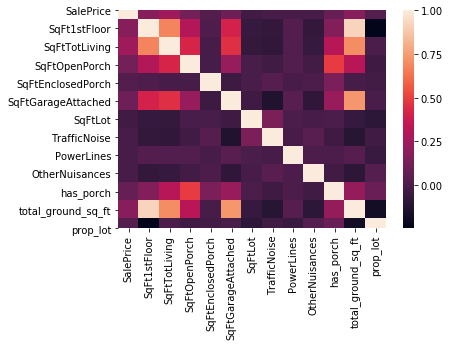

In [160]:
sns.heatmap(non_zero_df.corr())

Again the three claims I am currently exploring don't stick out like the other's. That's not necessarily a bad thing. My group wanted to focus on the claims that were less obvious which is why they have a lower correlation. They are less prevalent, but still a factor.

For the first model, I am going to use 'TrafficNoise', 'PowerLines', 'OtherNuisances', 'has_porch', and 'prop_lot' as the features to try and predict 'SalesPrice'. I will use the statsmodels linear regression as it provides a high level summary along with it. To start, I want to make a pairplot of the features and target variable.

In [164]:
# Create pair plot
var = non_zero_df[['TrafficNoise', 'PowerLines', 'OtherNuisances', 'has_porch', 'prop_lot', 'SalePrice']]
sns.pairplot(var)


Error in callback <function flush_figures at 0x7fa5327c2a60> (for post_execute):


KeyboardInterrupt: 